In [338]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import io
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from IPython.display import Image
import requests
sns.set_style('whitegrid')
%matplotlib inline
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,accuracy_score, classification_report,f1_score,precision_score,recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, learning_curve, validation_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, learning_curve, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss, auc, roc_auc_score
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_hist_gradient_boosting

In [339]:
# plot_learning_curve function from official scikit-learn documentation

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="orange",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="blue",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-', color="blue")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-', color="blue")
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

def plot_validation_curve(estimator, title, X, y, param_name, param_range, scoring="accuracy", axes=None, ylim=None, cv=10,
                            n_jobs=-1):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        scoring=scoring, n_jobs=n_jobs, cv=cv)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    ax = plt.subplot()

    plt.title("Validation Curve")
    plt.xlabel(param_name)
    plt.ylabel(scoring + " Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw, )
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="blue", lw=lw)
    plt.legend(loc="best")
    
    return plt

def plot_roc_auc_curve(estimator, x_test, y_test, y_pred, title="Receiver operating characteristic (ROC Curve)"):
    probs = estimator.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='orange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='blue', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    
    return plt


# 1. Data Reading and Preprocessing


In [340]:
wine = pd.read_csv('wine.csv')

In [341]:
wine.head()

,alcohol,sugar,pH,class
0,9.4,1.9,3.51,0.0
1,9.8,2.6,3.20,0.0
2,9.8,2.3,3.26,0.0
3,9.8,1.9,3.16,0.0
4,9.4,1.9,3.51,0.0


In [342]:
# Note: class 0 is red wine, class 1 is white wine.

In [343]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   alcohol  6497 non-null   float64
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   class    6497 non-null   float64
dtypes: float64(4)
memory usage: 203.2 KB


In [344]:
wine.describe()

,alcohol,sugar,pH,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,10.491801,5.443235,3.218501,0.753886
std,1.192712,4.757804,0.160787,0.430779
min,8.000000,0.600000,2.720000,0.000000
25%,9.500000,1.800000,3.110000,1.000000
50%,10.300000,3.000000,3.210000,1.000000
75%,11.300000,8.100000,3.320000,1.000000
max,14.900000,65.800000,4.010000,1.000000


In [345]:
data = wine[['alcohol', 'sugar', 'pH']].to_numpy()
target = wine['class'].to_numpy()

In [346]:
from sklearn.model_selection import train_test_split
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)


In [347]:
print(train_input.shape, test_input.shape)

(5197, 3) (1300, 3)


In [348]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(train_input)
train_scaled = ss.transform(train_input)
test_scaled = ss.transform(test_input)

In [349]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(train_scaled, train_target)
print(lr.score(train_scaled, train_target))
print(lr.score(test_scaled, test_target))

0.7808350971714451
0.7776923076923077


In [350]:
print(lr.coef_, lr.intercept_)

[[ 0.51270274  1.6733911  -0.68767781]] [1.81777902]


# 2. Decision Tree

In [351]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(train_input, train_target)
print("no-prune training score: ", dt.score(train_input, train_target))
print("no-prune testing score: ",dt.score(test_input, test_target))


no-prune training score:  0.996921300750433
no-prune testing score:  0.8584615384615385


In [352]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(train_input, train_target)
print("prune training score: ", dt.score(train_input, train_target))
print("prune testing score: ",dt.score(test_input, test_target))


prune training score:  0.8672310948624207
prune testing score:  0.8607692307692307


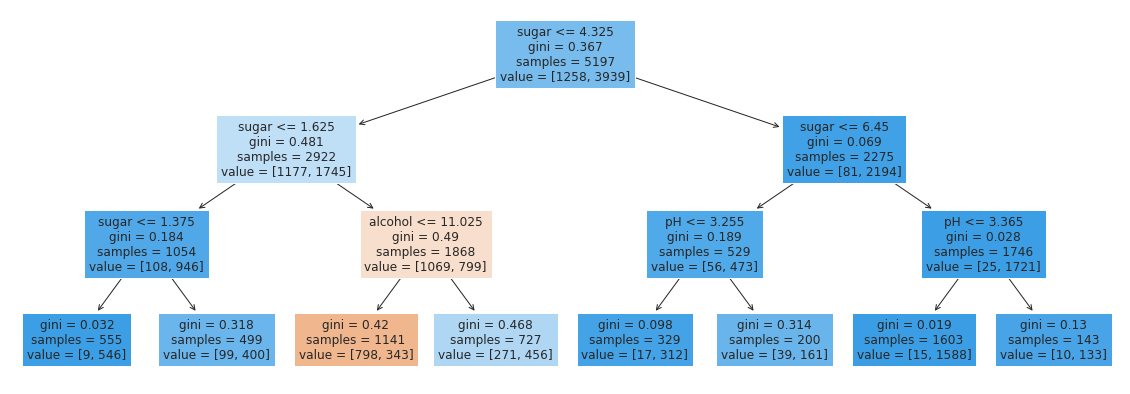

In [353]:
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(train_input, train_target)
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
plt.figure(figsize=(20,7))
plot_tree(dt, filled=True, feature_names=['alcohol', 'sugar', 'pH'], max_depth=3)
plt.show()


In [354]:
# Feature importances : Show the degree to contribute to decrease impurity(gini or entropy)

In [355]:
print(dt.feature_importances_)


[0.12345626 0.86862934 0.0079144 ]


In [356]:
# 5 KFold cross validation
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
scores = cross_validate(dt, train_input, train_target, cv=StratifiedKFold())
print(np.mean(scores['test_score']))

0.8412558303102096


In [357]:
# 10 KFold cross validation
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, train_input, train_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8335549132947977


In [358]:
# 10 KFold cross validation
splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(dt, test_input, test_target, cv=splitter)
print(np.mean(scores['test_score']))

0.8192307692307692


## Hyperparameter tuning using CV


In [359]:
from sklearn.model_selection import GridSearchCV
params = {'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004, 0.005]}

In [360]:
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, n_jobs=-1)

In [361]:
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'min_impurity_decrease': [0.001, 0.002, 0.003, 0.004,
                                                   0.005]})

In [362]:
dt = gs.best_estimator_
print("post-prune from training score: ", dt.score(train_input, train_target))

post-prune from training score:  0.8724263998460651


In [363]:
print(gs.best_estimator_)

DecisionTreeClassifier(min_impurity_decrease=0.001, random_state=42)


In [364]:
print(gs.cv_results_['mean_test_score'])

[0.86165044 0.85761105 0.85607111 0.85414803 0.85318557]


In [365]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['params'][best_index])

{'min_impurity_decrease': 0.001}


In [366]:
from scipy.stats import uniform, randint

In [367]:
params = {'min_impurity_decrease': uniform(0.0001, 0.001),
          'max_depth': randint(20, 50),
          'min_samples_split': randint(2, 25),
          'min_samples_leaf': randint(1,25),
         }

In [368]:
from sklearn.model_selection import RandomizedSearchCV
gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params,
                        n_iter=100, n_jobs=-1, random_state=42)
gs.fit(train_input, train_target)

RandomizedSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88c820f550>,
                                        'min_impurity_decrease': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88c82156a0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88c820fdf0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f88c8215c10>},
                   random_state=42)

In [369]:
print(gs.best_params_)

{'max_depth': 39, 'min_impurity_decrease': 0.00034102546602601173, 'min_samples_leaf': 7, 'min_samples_split': 13}


In [370]:
print("post-prune from validation: ", np.max(gs.cv_results_['mean_test_score']))

post-prune from validation:  0.8695428296438884


In [371]:
dt = gs.best_estimator_
print("post-prune from testing: ", dt.score(test_input, test_target))

post-prune from testing:  0.86


In [372]:
from sklearn.metrics import log_loss, auc, roc_auc_score
from sklearn import tree
depth = 40
tree_auc_trn, tree_auc_tst = np.zeros(depth), np.zeros(depth)
for i in range(1,depth):
    clf1 = tree.DecisionTreeClassifier(max_depth=i, criterion='gini')
    clf1 = clf1.fit(X_train, y_train)
    tree_auc_trn[i] = roc_auc_score(y_train, clf1.predict_proba(X_train)[:,1])
    tree_auc_tst[i] = roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1])

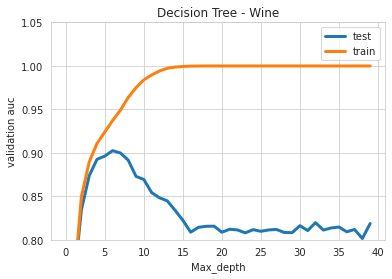

<Figure size 864x864 with 0 Axes>

In [373]:
from matplotlib import pyplot
pyplot.plot(tree_auc_tst, linewidth=3, label = "test")
pyplot.plot(tree_auc_trn, linewidth=3, label = "train")
pyplot.legend()
pyplot.ylim(0.8, 1.05)
pyplot.xlabel("Max_depth")
pyplot.title('Decision Tree - Wine')
pyplot.ylabel("validation auc")
plt.figure(figsize=(12,12))
pyplot.show()

# 3. Neural Networks

In [374]:
# Normalize all features
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,stratify=target, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,stratify=y_train, random_state=42)

In [375]:
X_mean = X_train.mean()
X_std = X_train.std()

normalize = lambda raw: (raw - X_mean) / X_std
denormalize = lambda raw: raw * X_std + X_mean
X_train = normalize(X_train)
X_val = normalize(X_val)
X_test = normalize(X_test)

In [376]:
result = {
    'Decision_Tree': {}, 
    'Neural_Network': {},
    'Boosting': {},
    'SVM': {},
    'k-NN': {}
}

In [377]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

hidden_layer_sizes =  3 , activation =  relu
F1 Score:  0.663264146164283
Training Accuracy:  0.7284099109935049
Testing Accuracy:  0.7269230769230769
Confusion Matrix
[[ 26 294]
 [ 61 919]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.30      0.08      0.13       320
         1.0       0.76      0.94      0.84       980

    accuracy                           0.73      1300
   macro avg       0.53      0.51      0.48      1300
weighted avg       0.64      0.73      0.66      1300

Cross Validation Score
[0.64804318 0.64804318 0.64804318 0.64804318 0.64804318 0.64804318
 0.64804318 0.64753128 0.64753128 0.64961155]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

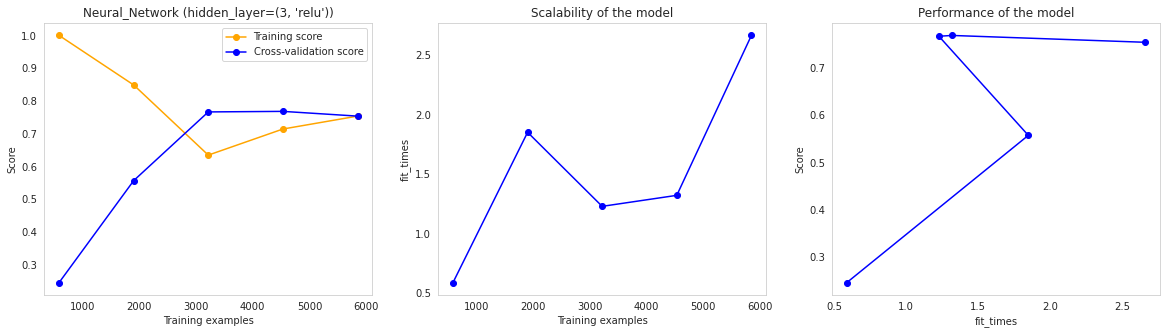

--------------------------------------------------
hidden_layer_sizes =  3 , activation =  tanh
F1 Score:  0.6884314783215469
Training Accuracy:  0.76088525378879
Testing Accuracy:  0.7623076923076924
Confusion Matrix
[[ 29 291]
 [ 18 962]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.62      0.09      0.16       320
         1.0       0.77      0.98      0.86       980

    accuracy                           0.76      1300
   macro avg       0.69      0.54      0.51      1300
weighted avg       0.73      0.76      0.69      1300

Cross Validation Score
[0.88609204 0.86271508 0.84377655 0.85846154 0.86943819 0.84907146
 0.80941784 0.87035042 0.8606267  0.86648037]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

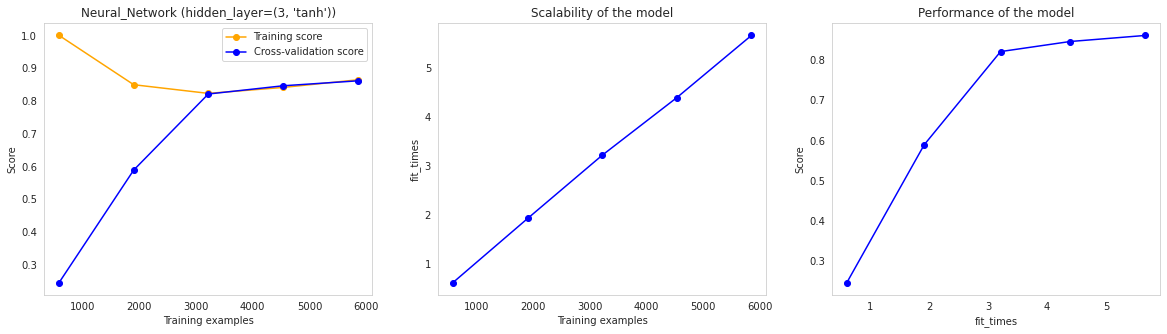

--------------------------------------------------
hidden_layer_sizes =  (3, 3) , activation =  tanh
F1 Score:  0.8000586347389653
Training Accuracy:  0.8154919413038249
Testing Accuracy:  0.8107692307692308
Confusion Matrix
[[154 166]
 [ 80 900]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.66      0.48      0.56       320
         1.0       0.84      0.92      0.88       980

    accuracy                           0.81      1300
   macro avg       0.75      0.70      0.72      1300
weighted avg       0.80      0.81      0.80      1300

Cross Validation Score
[0.87846749 0.8581312  0.84602059 0.8518297  0.85483009 0.86872305
 0.81139286 0.86853301 0.85597894 0.87929387]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

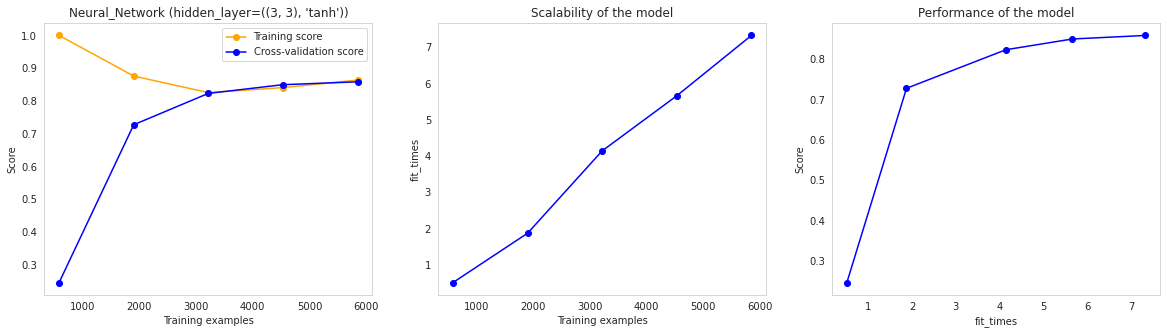

--------------------------------------------------
hidden_layer_sizes =  (5, 5, 5) , activation =  tanh
F1 Score:  0.8556295775230687
Training Accuracy:  0.8616790955015636
Testing Accuracy:  0.8615384615384616
Confusion Matrix
[[196 124]
 [ 56 924]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.78      0.61      0.69       320
         1.0       0.88      0.94      0.91       980

    accuracy                           0.86      1300
   macro avg       0.83      0.78      0.80      1300
weighted avg       0.86      0.86      0.86      1300

Cross Validation Score
[0.87557594 0.85557483 0.83931255 0.85507712 0.87885223 0.85618431
 0.8181152  0.85460954 0.87035042 0.90179718]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa

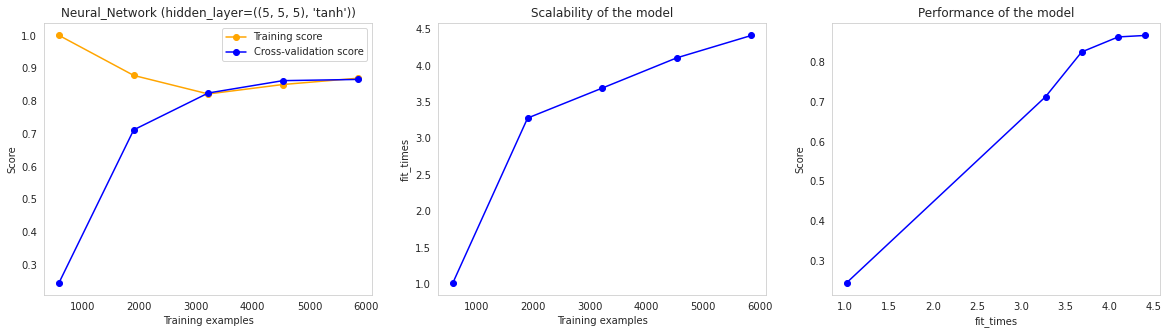

--------------------------------------------------
CPU times: user 3min 14s, sys: 120 ms, total: 3min 14s
Wall time: 5min 52s


In [378]:
%%time
task = "Neural_Network"
# Multi-layer Perceptron Classifier
from sklearn.neural_network import MLPClassifier

f1 = []
train_acc = []
test_acc = []
params = [
    ((3), 'relu'),
    ((3), 'tanh'),
    ((3, 3), 'tanh'),
    ((5, 5, 5), 'tanh'),
]
for k in params:
    print("hidden_layer_sizes = ", k[0], ", activation = ", k[1])
    clf = MLPClassifier(hidden_layer_sizes=k[0], max_iter=300,activation = k[1],solver='adam',random_state=1)
    fit_tree = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=10, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])
    
    # Learning Curve
    plot_learning_curve(clf, f"{task} (hidden_layer={k})", data, target, axes=None, cv=10, n_jobs=4)
    plt.show()

    
    print("--------------------------------------------------")   


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (60) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (90) reached and the optimization hasn't converged yet.
  warnings.warn(


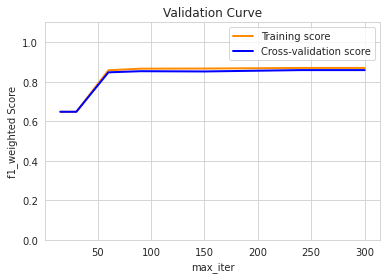

In [379]:
# Validation Curve
chosen_size = (3)
chosen_activation = 'tanh'
max_iter_list = [15, 30, 60, 90, 150, 240, 300]
plot_validation_curve(MLPClassifier(hidden_layer_sizes=k[0],activation = chosen_activation,solver='adam',random_state=1), 
                      f"{task}: hidden_layer_sizes={chosen_size}, max_iter", data, target, "max_iter", max_iter_list, scoring="f1_weighted", axes=None, cv=5, n_jobs=4)

plt.show()

# 4-1. Boosting

In [380]:
# 1. Random Forest

In [381]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_jobs=-1, random_state=42)
scores_r = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores_r['train_score']), np.mean(scores_r['test_score']))
      

0.9973541965122431 0.8905151032797809


In [382]:
# -> overfitting to train set

In [383]:
rf.fit(train_input, train_target)
print(rf.feature_importances_)

[0.23167441 0.50039841 0.26792718]


In [384]:
# Compared to decision tree ([0.12345626 0.86862934 0.0079144 ]),importance of sweetness is lower, for others a little higher.
# It helps to decrease overfitting and increase generalization.

In [385]:
# OOB(out of bag) sample training
rf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=42)
rf.fit(train_input, train_target)
print(rf.oob_score_)

0.8934000384837406


<!-- # Normalize all features
# from sklearn.model_selection import train_test_split
# train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, random_state=42)
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)
X_mean = train_input.mean()
X_max = train_input.max()
X_min = train_input.min()
normalize = lambda raw: (raw - X_mean) / (X_max - X_min)
denormalize = lambda raw: raw * (X_max - X_min) + X_mean
train_input = normalize(train_input)
val_input = normalize(X_val)
test_input = normalize(X_test)
train_input.describe() -->

# 5. KNN

In [386]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state=42)

In [387]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9)

In [388]:
knn.score(X_train, y_train)

0.8835698821265335

In [389]:
knn.score(X_val, y_val)

0.8875

In [390]:
print(knn._fit_X)


[[11.4   1.25  2.95]
 [ 9.1   8.    3.23]
 [ 9.1  13.4   3.06]
 ...
 [11.5   3.    3.16]
 [12.3   9.    3.13]
 [11.1   1.4   3.34]]


In [391]:
print(knn._y)

[1 1 1 ... 0 1 1]


In [392]:
best_val = 0
best_n = 0
best_weights = ""
best_metric = ""
for n in range(1,20):
    for weights in ["uniform", "distance"]:
        for metric in ["euclidean", "manhattan","minkowski"]:
            knn = KNeighborsClassifier(n_neighbors=n, weights=weights, metric=metric)
            knn.fit(X_train,y_train)
            val_score = knn.score(X_val, y_val)
            if val_score > best_val:
                best_val = val_score
                best_n = n
                best_weights = weights
                best_metric = metric
print("Best validation score: ", best_val)
print("Best n: ", best_n)
print("Best weights method: ", best_weights)
print("Best distance metric: ", best_metric)

Best validation score:  0.9009615384615385
Best n:  17
Best weights method:  distance
Best distance metric:  euclidean


In [393]:
best_n = 17
best_weights = "distance"
best_metric = "euclidean"
knn = KNeighborsClassifier(n_neighbors=best_n, weights=best_weights, metric=best_metric)
knn.fit(X_train,y_train)
print("Training score: ", knn.score(X_train, y_train))
print("Test score: ", knn.score(X_test, y_test))

Training score:  0.9971133028626413
Test score:  0.8815384615384615


In [394]:
error_rate = []
for n in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=n, weights="distance", metric="euclidean")
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_val)
    error_rate.append(np.mean(pred_i != y_val))

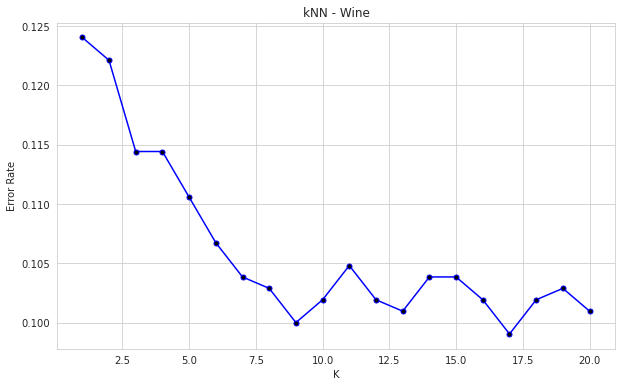

In [395]:
plt.figure(figsize=(10,6))
plt.plot(range(1,21),error_rate,color='blue', marker='o',
         markerfacecolor='black', markersize=5)
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.title('kNN - Wine')
plt.show()

In [396]:
kn = range(5,35,5)
kauc_trn, kauc_tst = np.zeros(len(kn)), np.zeros(len(kn))
for i, k in zip(range(0, len(kn)), kn):
    clf1 = KNeighborsClassifier(n_neighbors=k, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, p=2, weights='uniform')
    clf1 = clf1.fit(X_train, y_train)
    pred_tst = clf1.predict_proba(X_test)[:,1]
    pred_trn = clf1.predict_proba(X_train)[:,1]
    kauc_tst[i] = roc_auc_score(y_test, pred_tst)
    kauc_trn[i] = roc_auc_score(y_train, pred_trn)

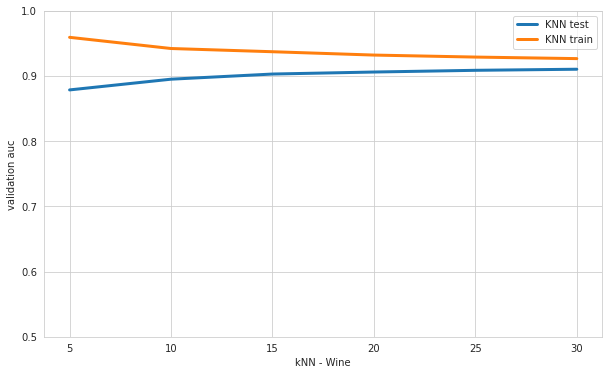

In [397]:
plt.figure(figsize=(10,6))
plt.plot(kn, kauc_tst, linewidth=3, label = "KNN test")
plt.plot(kn, kauc_trn, linewidth=3, label = "KNN train")
plt.legend()
plt.ylim(0.5, 1.0)
plt.xlabel("kNN - Wine")
plt.ylabel("validation auc")
plt.show()

# 6. SVM

kernel =  linear
F1 Score:  0.6263363639459256
Training Accuracy:  0.7623286023574694
Testing Accuracy:  0.7376923076923076
Confusion Matrix
[[  0 341]
 [  0 959]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       341
         1.0       0.74      1.00      0.85       959

    accuracy                           0.74      1300
   macro avg       0.37      0.50      0.42      1300
weighted avg       0.54      0.74      0.63      1300

Cross Validation Score
[0.81172457 0.76931953 0.68015967 0.7057435  0.75046113 0.75561423
 0.70933529 0.7202815  0.64753128 0.73606364]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: 

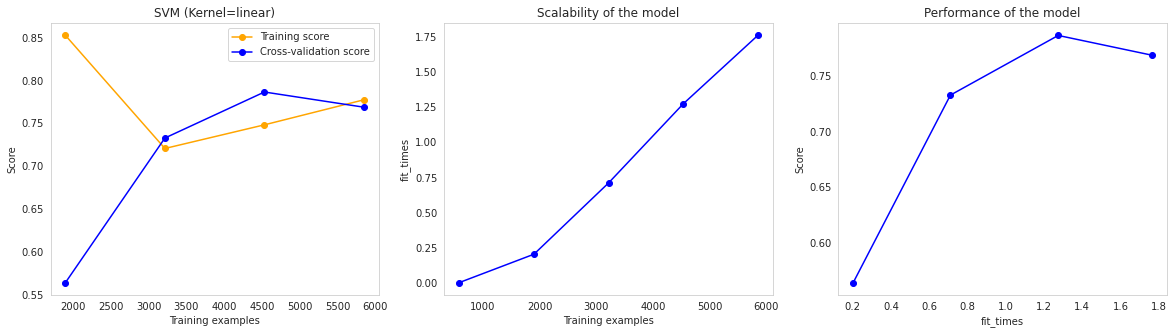

--------------------------------------------------
kernel =  poly
F1 Score:  0.8093134786002469
Training Accuracy:  0.8296848688958384
Testing Accuracy:  0.8223076923076923
Confusion Matrix
[[168 173]
 [ 58 901]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.74      0.49      0.59       341
         1.0       0.84      0.94      0.89       959

    accuracy                           0.82      1300
   macro avg       0.79      0.72      0.74      1300
weighted avg       0.81      0.82      0.81      1300

Cross Validation Score
[0.82805124 0.84372402 0.72710342 0.79844938 0.83589635 0.82954776
 0.76370496 0.82062173 0.85534298 0.89392266]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: 

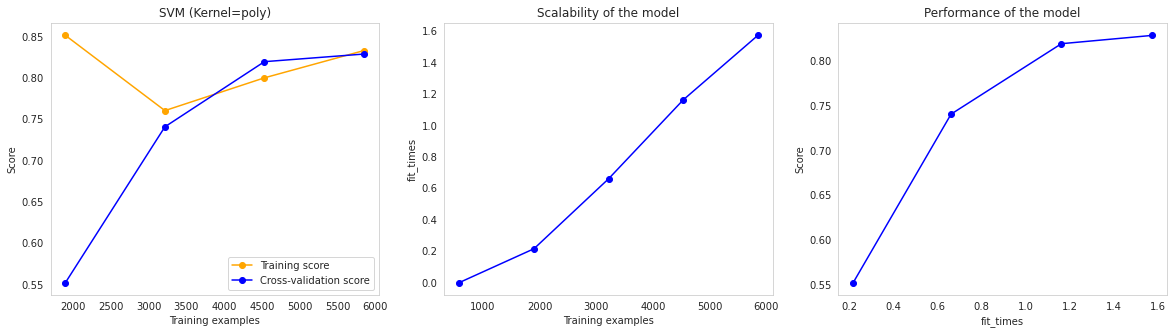

--------------------------------------------------
kernel =  rbf
F1 Score:  0.8314234952083558
Training Accuracy:  0.8429155641087323
Testing Accuracy:  0.84
Confusion Matrix
[[192 149]
 [ 59 900]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.76      0.56      0.65       341
         1.0       0.86      0.94      0.90       959

    accuracy                           0.84      1300
   macro avg       0.81      0.75      0.77      1300
weighted avg       0.83      0.84      0.83      1300

Cross Validation Score
[0.86368611 0.87806521 0.7883325  0.84354117 0.87426721 0.81676561
 0.75290339 0.81441383 0.83290123 0.85504926]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: 

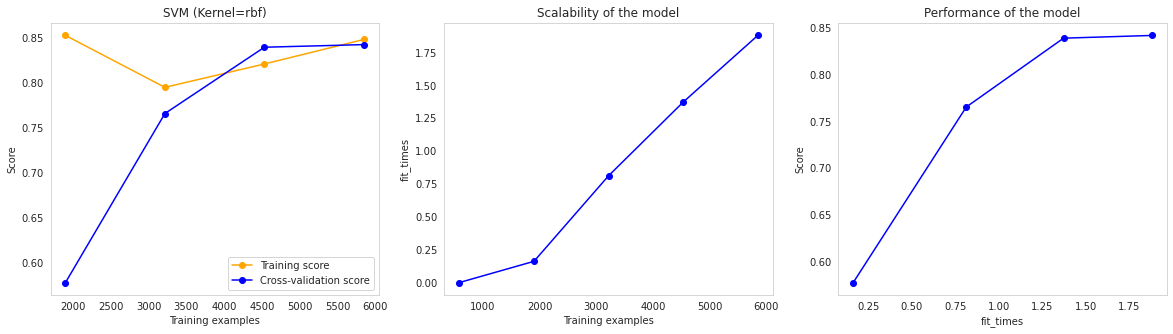

--------------------------------------------------
kernel =  sigmoid
F1 Score:  0.5869391317966945
Training Accuracy:  0.6379600673562665
Testing Accuracy:  0.6153846153846154
Confusion Matrix
[[ 33 308]
 [192 767]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.15      0.10      0.12       341
         1.0       0.71      0.80      0.75       959

    accuracy                           0.62      1300
   macro avg       0.43      0.45      0.44      1300
weighted avg       0.56      0.62      0.59      1300

Cross Validation Score
[0.607658   0.61490665 0.61818812 0.62049406 0.61933782 0.61561288
 0.5354011  0.5391952  0.58565129 0.51884813]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 173, in fit
    y = self._validate_targets(y)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/svm/_base.py", line 558, in _validate_targets
    raise ValueError(
ValueError: The number of classes has to be greater than one; got 1 class

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: 

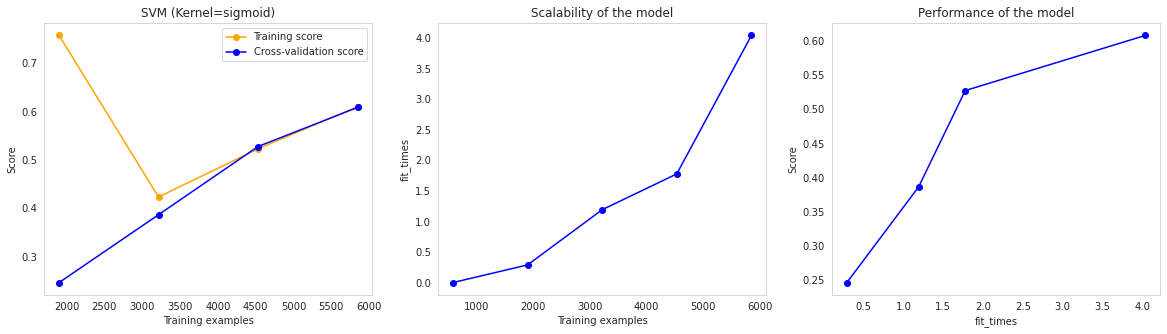

--------------------------------------------------
CPU times: user 1min 39s, sys: 1.4 s, total: 1min 40s
Wall time: 3min 2s


In [398]:
%%time
task = "SVM"
from sklearn import svm

for k in ['linear', 'poly', 'rbf', 'sigmoid']:
    print("kernel = ", k)
    clf = svm.SVC(decision_function_shape='ovo', kernel=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=10, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])

    plot_learning_curve(clf, f"{task} (Kernel={k})", data, target, axes=None, cv=10, n_jobs=4)

    plt.show()
    print("--------------------------------------------------")


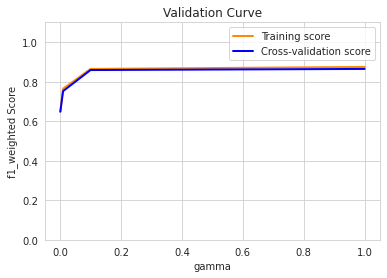

In [399]:
# Validation Curve
param_range = np.logspace(-3, 0, 4)
plot_validation_curve(svm.SVC(kernel='rbf'), 
                      f"{task}: RBF - gamma, max_iter", data, target, "gamma", param_range, scoring="f1_weighted", axes=None, cv=10, n_jobs=4)
plt.show()

# 4-2 Boosting

Classifier =  AdaBoost
F1 Score:  0.8600158604282314
Training Accuracy:  0.8660091412076016
Testing Accuracy:  0.8615384615384616
Confusion Matrix
[[240 101]
 [ 79 880]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.70      0.73       341
         1.0       0.90      0.92      0.91       959

    accuracy                           0.86      1300
   macro avg       0.82      0.81      0.82      1300
weighted avg       0.86      0.86      0.86      1300

Cross Validation Score
[0.8751073  0.84907617 0.80193556 0.82454189 0.86609423 0.84133845
 0.84202495 0.87790323 0.88732877 0.89667331]


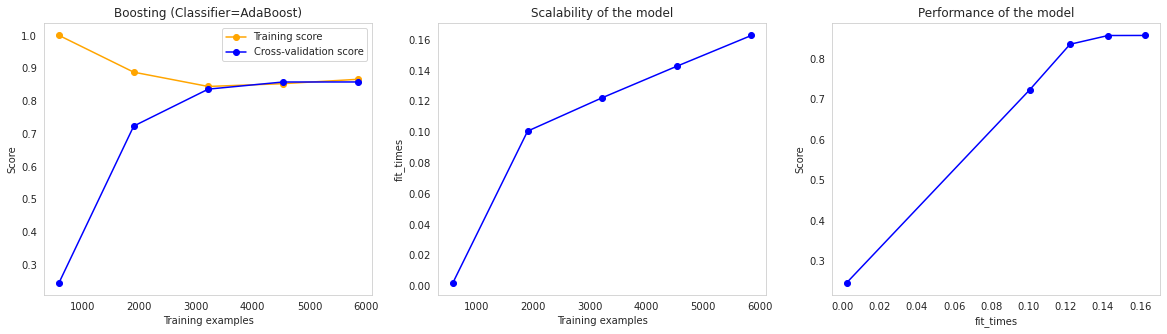

--------------------------------------------------
Classifier =  HistGradientBoosting
F1 Score:  0.8655739507390896
Training Accuracy:  0.9759441905220111
Testing Accuracy:  0.8653846153846154
Confusion Matrix
[[255  86]
 [ 89 870]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.74      0.75      0.74       341
         1.0       0.91      0.91      0.91       959

    accuracy                           0.87      1300
   macro avg       0.83      0.83      0.83      1300
weighted avg       0.87      0.87      0.87      1300

Cross Validation Score
[0.87486546 0.85331174 0.80933585 0.82533861 0.85215778 0.87215164
 0.80542324 0.86684564 0.86687301 0.86351555]


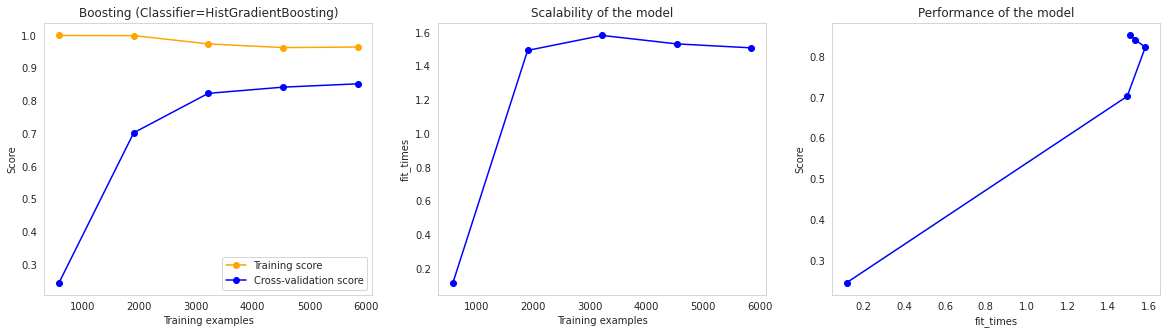

--------------------------------------------------
Classifier =  GradientBoosting
F1 Score:  0.862276413865309
Training Accuracy:  0.8821265335578542
Testing Accuracy:  0.8630769230769231
Confusion Matrix
[[246  95]
 [ 83 876]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.75      0.72      0.73       341
         1.0       0.90      0.91      0.91       959

    accuracy                           0.86      1300
   macro avg       0.82      0.82      0.82      1300
weighted avg       0.86      0.86      0.86      1300

Cross Validation Score
[0.877206   0.86346347 0.81144266 0.83121535 0.87007805 0.8568935
 0.81952384 0.87138952 0.87110893 0.89356908]


/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 423, in fit
    y = self._validate_y(y, sample_weight)
  File "/home/ceres-v2/miniconda3/envs/AI/lib/python3.9/site-packages/sklearn/ensemble/_gb.py", line 1107, in _validate_y
    raise ValueError("y contains %d class after sample_weight "
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.

  warnings.warn("Estimator fit failed. The score on this train-test"

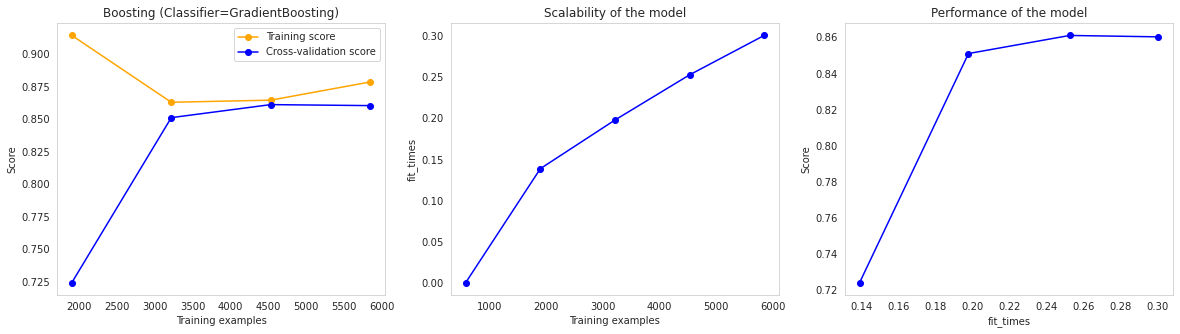

--------------------------------------------------


TypeError: __init__() got an unexpected keyword argument 'subsample'

In [400]:
%%time
task = "Boosting"
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (AdaBoostClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier)

base_estim = DecisionTreeClassifier(max_depth=1, max_features=0.06)

f1 = []
train_acc = []
test_acc = []
params = ["AdaBoost", "GradientBoosting", "HistGradientBoosting"]

for k, clf in [
    ("AdaBoost", AdaBoostClassifier(base_estimator=base_estim,
                        # n_estimators=100,
                        learning_rate=0.5,
                        random_state=42)),
    ("HistGradientBoosting", HistGradientBoostingClassifier(max_iter=300,
                                      validation_fraction=0.1,
                                      n_iter_no_change=15,
                                      verbose=0,
                                      random_state=42)),
    ("GradientBoosting", GradientBoostingClassifier( # n_estimators=100,
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=42)),
]:
    print("Classifier = ", k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    result[task][k] = {
        "f1" : f1_score(y_test,y_pred, average='weighted'),
        "training_acc": clf.score(X_train, y_train),
        "testing_acc": clf.score(X_test, y_test),
        "confusion_mat": confusion_matrix(y_test, y_pred),
        "classification_report": classification_report(y_test,y_pred),
        "cross_validation_score": cross_val_score(clf, data, target, cv=10, scoring='f1_weighted'),
    }
    print("F1 Score: ", result[task][k]["f1"])
    print("Training Accuracy: ", result[task][k]["training_acc"])
    print("Testing Accuracy: ", result[task][k]["testing_acc"])
    print("Confusion Matrix")
    print(result[task][k]["confusion_mat"])
    print("Classification Report")
    print(result[task][k]["classification_report"])
    print("Cross Validation Score")
    print(result[task][k]["cross_validation_score"])
    
    # Add to lists
    f1.append(result[task][k]["f1"])
    train_acc.append(result[task][k]["training_acc"])
    test_acc.append(result[task][k]["testing_acc"])

    plot_learning_curve(clf, f"{task} (Classifier={k})", data, target, axes=None, cv=10, n_jobs=4)
    plt.show()
    print("--------------------------------------------------")

    
# Validation Curve
n_estimator_list = [5, 10 , 20, 50, 100, 200, 300, 500, 1000, 1500, 2000]
plot_validation_curve(AdaBoostClassifier(
                                 subsample=0.67,
                                 max_features=0.06,
                                 validation_fraction=0.1,
                                 n_iter_no_change=15,
                                 verbose=0,
                                 random_state=42), f"{task}: GradientBoosting - n_estimators", data, target, "n_estimators", n_estimator_list, scoring="f1_weighted", axes=None, cv=10, n_jobs=4)
plt.show()